In [ ]:
# load in the structures destroyed (in California?) 
# Load in all of the structures destroyed 

In [17]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import xarray as xr
import zarr
import numpy as np

from windrose import WindroseAxes

In [27]:
# load in structures destroyed Alexandre 2016 https://esajournals.onlinelibrary.wiley.com/doi/10.1002/eap.1376
# Step 1: Load CSV file into a pandas DataFrame
csv_file = 's3://carbonplan-risks/structures/alexandre2016/digitized_buildings_2000_2010.csv'
df = pd.read_csv(csv_file)
# Step 2: Create geometry from X, Y columns
geometry = [Point(xy) for xy in zip(df['X'], df['Y'])]
# Step 3: Create GeoDataFrame with the correct CRS
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:5070")  # EPSG:4269 is NAD83

In [3]:
# gdf = gdf.to_crs('EPSG:4326')

In [5]:
historical_path = "s3://carbonplan-risks/riley2025/2011climaterun"
future_path = "s3://carbonplan-risks/riley2025/2047climaterun"
riley = {}
riley['2011'] = xr.open_zarr(historical_path+'.zarr')
riley['2047'] = xr.open_zarr(future_path+'.zarr')

In [18]:
lat_min, lat_max = 33.5, 34.5
lon_min, lon_max = -117.6, -116
xy = gpd.points_from_xy([lon_min, lon_max],[lat_min, lat_max], crs="EPSG:4326")
xy = xy.to_crs('EPSG:5070')
x_min, x_max = xy.x.min(), xy.x.max()
y_min, y_max = xy.y.min(), xy.y.max()

In [33]:
subset = gdf.cx[x_min:x_max, y_min:y_max]
subset = subset[subset['year']==2003]

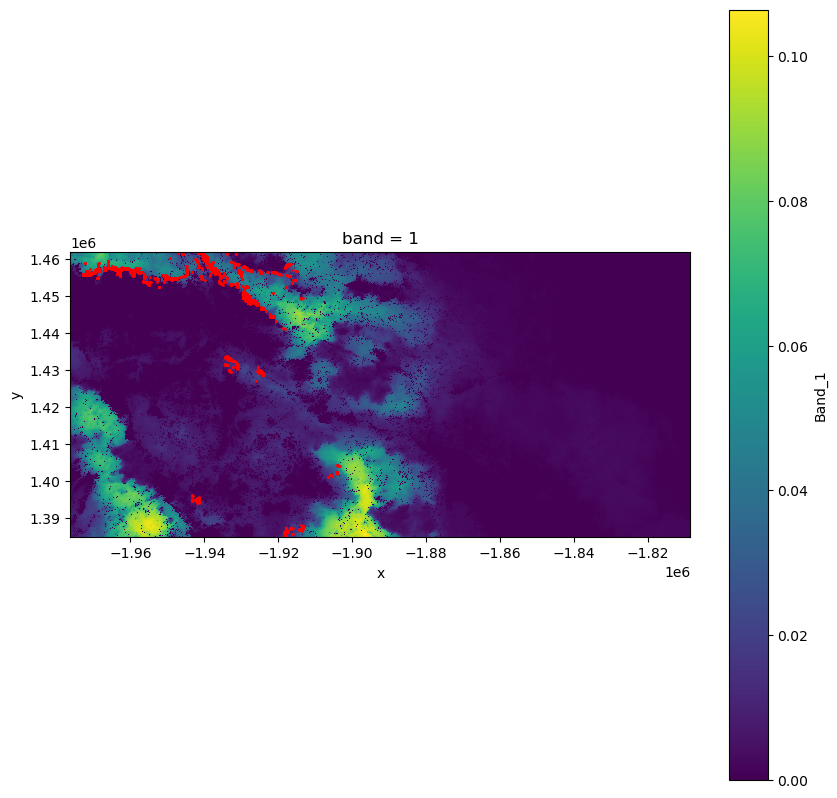

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
riley['2011'].sel(x=slice(x_min, x_max), y=slice(y_max, y_min), band=1).BP.plot(ax=ax)
subset.plot(ax=ax, color='red', markersize=1)
# plt.title("Burned Structures Located in box in Northern California")
plt.show()

In [46]:
eaton = gpd.read_file('s3://carbonplan-risks/structures/Eaton/DINS_2025_Eaton_Public_View.shp')
 = eaton.to_crs('EPSG:5070')

In [47]:
x_min, x_max = eaton.geometry.x.min(), eaton.geometry.x.max()
y_min, y_max = eaton.geometry.y.min(), eaton.geometry.y.max()

In [49]:
riley['2011'].sel(x=slice(x_min, x_max), y=slice(y_max, y_min), band=1).BP.plot(ax=ax)

In [9]:
important_days = xr.open_zarr('s3://carbonplan-risks/era5/fire_weather_days_v2.zarr')

In [10]:
important_days.sel(latitude=34.17, longitude=-118.09, method='nearest')

<xarray.Dataset> Size: 4MB
Dimensions:                                       (time: 262968)
Coordinates:
    latitude                                      float32 4B 34.25
    longitude                                     float32 4B 235.0
  * time                                          (time) datetime64[ns] 2MB 1...
Data variables:
    10m_wind_gust_since_previous_post_processing  (time) float32 1MB dask.array<chunksize=(10000,), meta=np.ndarray>
    sfcWindfromdir                                (time) float32 1MB dask.array<chunksize=(10000,), meta=np.ndarray>

In [13]:
def plot_windrose(winddir, windspeeds, bins=np.arange(0, 20, 1), title='Wind gusts (m/s)'):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'windrose'})
    ax.bar(winddir.values, windspeeds.values, bins=bins, normed=True, opening=0.8, edgecolor='white')
    
    # Customize the plot
    ax.set_legend(title=title)
    
    return fig, ax

In [15]:
def lon_to_180(ds):
    lon = ds["longitude"].where(ds["longitude"] < 180, ds["longitude"] - 360)
    ds = ds.assign_coords(longitude=lon)
    return ds

Text(0.5, 0.98, '34.17, -118.09')

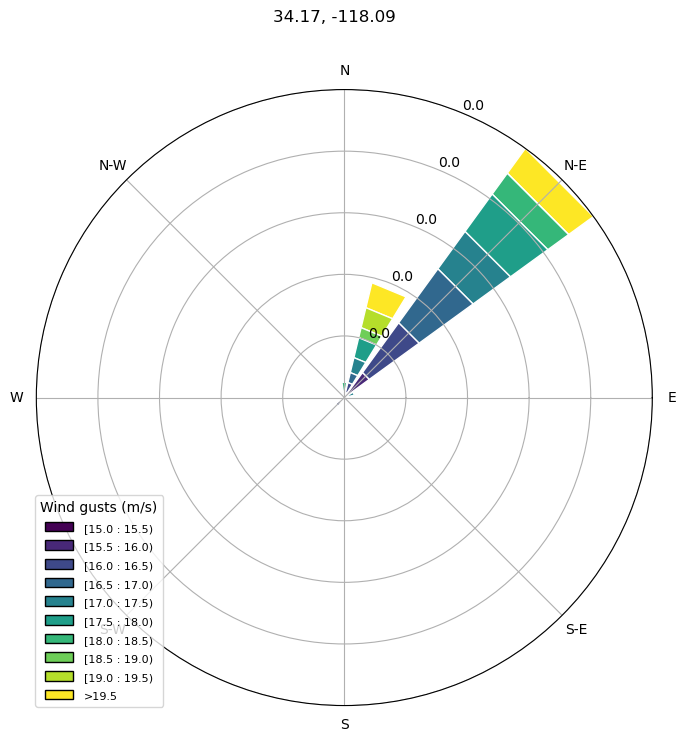

In [18]:
lat = 34.17
lon = -118.09
important_days_to_plot = lon_to_180(important_days).sel(latitude=lat, longitude=lon, method='nearest').compute()
fig, ax = plot_windrose(important_days_to_plot['sfcWindfromdir'], important_days_to_plot['10m_wind_gust_since_previous_post_processing'], bins=np.arange(15, 20, 0.5))
fig.suptitle(f'{lat}, {lon}')

Text(0.5, 1.0, 'Eaton fire 2025')

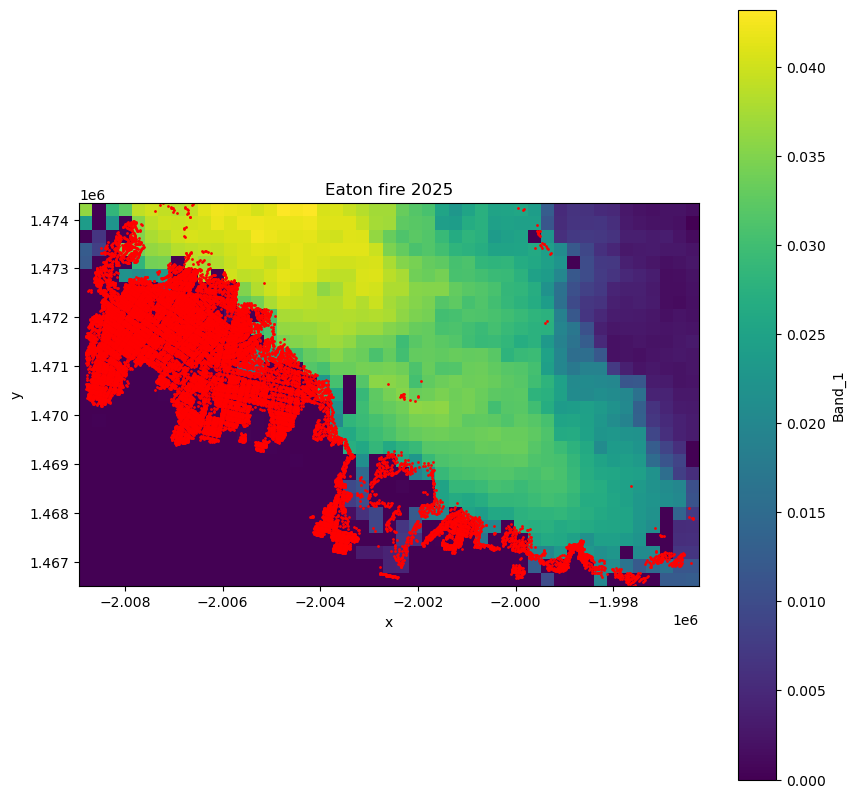

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))
riley['2011'].sel(x=slice(x_min, x_max), y=slice(y_max, y_min), band=1).BP.plot(ax=ax)
eaton.plot(ax=ax, color='red', markersize=1)
plt.title('Eaton fire 2025')

In [22]:
# Step 5: Load California boundary (state outline) using Geopandas' built-in datasets
california = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# california = california[california.name == 'California']

# # Step 6: Filter out points within California's boundaries
# gdf_ca = gdf[gdf.geometry.within(california.geometry.iloc[0])]

/tmp/ipykernel_1508/3021607757.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  california = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
